In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# !pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

The tensorboard module is not an IPython extension.


In [4]:
import os, sys, datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras import *
import keras
import h5py

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D

from random import shuffle

from IPython.display import display
from IPython.display import Image as _Imgdis
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Using TensorFlow backend.


In [5]:
from google.colab import drive, files
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# dataset source - https://www.kaggle.com/epreis/rxtorax 

effusion_train_test_dataset_dir = '/content/gdrive/My Drive/Colab Notebooks/dataset/train_test/effusion'
normal_train_test_dataset_dir = '/content/gdrive/My Drive/Colab Notebooks/dataset/train_test/normal'

In [7]:
all_effusion_images = [f for f in os.listdir(effusion_train_test_dataset_dir) if os.path.isfile(os.path.join(effusion_train_test_dataset_dir, f))]
all_normal_images = [f for f in os.listdir(normal_train_test_dataset_dir) if os.path.isfile(os.path.join(normal_train_test_dataset_dir, f))]

print("Number of effusion samples: "+str(len(all_effusion_images)))
print("Number of normal samples: "+str(len(all_normal_images)))

Number of effusion samples: 496
Number of normal samples: 496


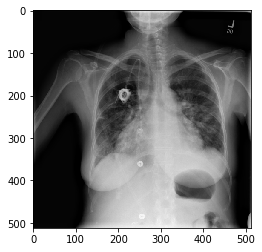

In [8]:
for i in range(0,1):
  img = mpimg.imread(effusion_train_test_dataset_dir + "/" + all_effusion_images[i])
  imgplot = plt.imshow(img)
  plt.show()

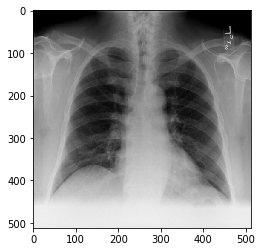

In [9]:
for i in range(0,1):
  img = mpimg.imread(normal_train_test_dataset_dir + "/" + all_normal_images[i])
  imgplot = plt.imshow(img)
  plt.show()

In [0]:
# combining normal and effusion samples

all_samples = []
effusion_samples = []
normal_samples = []  

for sample in all_effusion_images:
  effusion_samples.append(effusion_train_test_dataset_dir + "/" + sample)

for sample in all_normal_images:
  normal_samples.append(normal_train_test_dataset_dir + "/" + sample)

all_samples = effusion_samples + normal_samples
shuffle(all_samples)

In [11]:
print(effusion_samples[0])
print(normal_samples[0])
print("Total samples: " + str(len(all_samples)))

/content/gdrive/My Drive/Colab Notebooks/dataset/train_test/effusion/effusion321.png
/content/gdrive/My Drive/Colab Notebooks/dataset/train_test/normal/normal148.png
Total samples: 992


In [12]:
# splitting images into features and labels
# loading all images into an ndarray

features_dirs = all_samples
y = []

channels = 1
im_height = 64
im_width = 64

image_array = np.ndarray(shape = (len(all_samples), 
                                  im_height,
                                  im_width, 
                                  channels),
                         dtype = np.float32)
i = 0

for sample in features_dirs:
    
    img = load_img(sample, grayscale=True)
    img.thumbnail((im_width, im_height))
    x = img_to_array(img)  
    x = x.reshape((64, 64, 1))
    image_array[i] = x
    i+=1
    
    if 'normal' in sample:
      y.append(0)
    else:
      y.append(1)
      
y = np.array((y))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# saving loaded dataset as a 

with h5py.File('X.h5', 'w') as X_hdf5:
  X_hdf5.create_dataset('X', data = image_array)
  
with h5py.File('y.h5', 'w') as y_hdf5:
  y_hdf5.create_dataset('y', data = y)

In [15]:
with h5py.File('X.h5', 'r') as hf:
    image_array_h5 = hf['X'][:]
    
with h5py.File('y.h5', 'r') as hf:
    y_h5 = hf['y'][:]

print("Features shape: " + str(image_array_h5.shape))
print("Labels shape: " + str(y_h5.shape))

Features shape: (992, 64, 64, 1)
Labels shape: (992,)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(image_array, y, test_size = 0.2, random_state = 0)

In [0]:
num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
def conv_model():
  model = Sequential()

  model.add(layers.Convolution2D(64, kernel_size=(3, 3),
                   activation='relu',
                   input_shape=(64,64,1)))
  
  model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.5))

  model.add(layers.Flatten())

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation='softmax'))
  
  return model

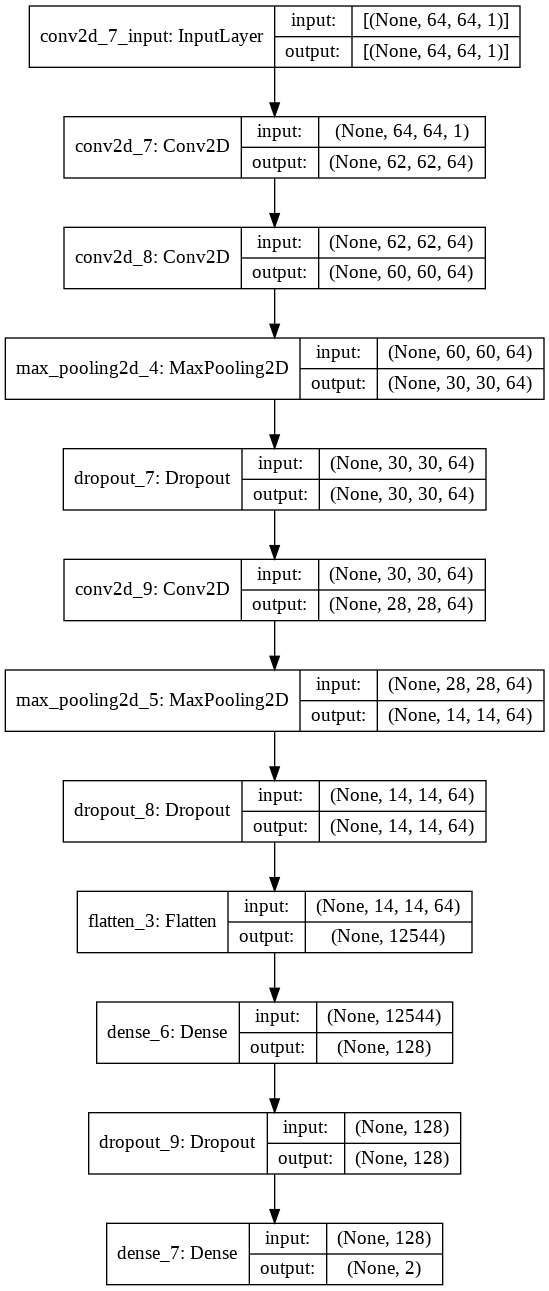

In [43]:
model = conv_model()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# %tensorboard --logdir logs

model.fit(X_train, y_train,
          batch_size=32,
          epochs=25,
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 793 samples, validate on 199 samples
Epoch 1/25
793/793 [==============================] - 1s 1ms/sample - loss: 0.0927 - acc: 0.9760 - val_loss: 4.2843 - val_acc: 0.6482
Epoch 2/25
793/793 [==============================] - 0s 510us/sample - loss: 0.0802 - acc: 0.9735 - val_loss: 3.7695 - val_acc: 0.6281
Epoch 3/25
793/793 [==============================] - 0s 511us/sample - loss: 0.0362 - acc: 0.9874 - val_loss: 3.7742 - val_acc: 0.6332
Epoch 4/25
793/793 [==============================] - 0s 513us/sample - loss: 0.0527 - acc: 0.9811 - val_loss: 3.9373 - val_acc: 0.6482
Epoch 5/25
793/793 [==============================] - 0s 502us/sample - loss: 0.0589 - acc: 0.9786 - val_loss: 3.8651 - val_acc: 0.6734
Epoch 6/25
793/793 [==============================] - 0s 515us/sample - loss: 0.1132 - acc: 0.9622 - val_loss: 2.5622 - val_acc: 0.6734
Epoch 7/25
793/793 [==============================] - 0s 521us/sample - loss: 0.0460 - acc: 0.9849 - val_loss: 3.5193 - val_acc: 0.6633
Epoc

In [0]:
model.save("model.h5")

files.download('model.h5')
files.download('X.h5')
files.download('y.h5')

In [0]:
def plot_figures(figures, n_rows, n_cols):

    fig, axes = plt.subplots(ncols = n_cols, 
                                 nrows = n_rows)
    for ind, title in enumerate(figures):
        axes.ravel()[ind].imshow(figures[title], 
                                     cmap=plt.gray())
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout()

In [0]:
def img_to_numpy_array(img_object):
  img = load_img(img_object, grayscale=True)
  img.thumbnail((im_width, im_height))
  x = img_to_array(img)  
  x = x.reshape((1, 64, 64, 1))
  return x

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


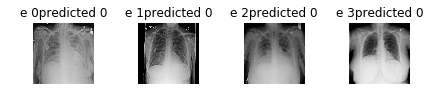

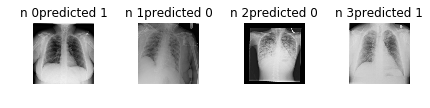

In [40]:
test_effusion_dir = '/content/gdrive/My Drive/Colab Notebooks/dataset/validation/effusion'
test_normal_dir = '/content/gdrive/My Drive/Colab Notebooks/dataset/validation/normal'

total_effusion_test_images = [f for f in os.listdir(test_effusion_dir) if os.path.isfile(os.path.join(test_effusion_dir, f))]
total_normal_test_images = [f for f in os.listdir(test_normal_dir) if os.path.isfile(os.path.join(test_normal_dir, f))]

effusion_figures_list = []
normal_figures_list = []
prediction_effusion = []
prediction_normal = []

for i in range(len(total_effusion_test_images)):
  effusion_img_path = test_effusion_dir + '/' + total_effusion_test_images[i]
  normal_img_path = test_normal_dir + '/' + total_normal_test_images[i]
  img1 = mpimg.imread(effusion_img_path)
  img2 = mpimg.imread(normal_img_path)  
  effusion_array = img_to_numpy_array(effusion_img_path)
  normal_array = img_to_numpy_array(normal_img_path)
  prediction_effusion.append(1 if model.predict(effusion_array)[0][0] > 0.5 else 0)
  prediction_normal.append(1 if model.predict(normal_array)[0][0] > 0.5 else 0)
  effusion_figures_list.append(img1)
  normal_figures_list.append(img2)
  
number_of_im = 4
effusion_figures = {'e '+str(i)+'predicted '+str(prediction_effusion[i]): effusion_figures_list[i] for i in range(number_of_im)}
normal_figures = {'n '+str(i)+'predicted '+str(prediction_normal[i]): normal_figures_list[i] for i in range(number_of_im)}

plot_figures(effusion_figures, 1, 4)  
plot_figures(normal_figures, 1, 4)  
